Forecast UK Trade Data
1. Data Ingestion and Preprocessing
The script begins by importing essential libraries for data manipulation (pandas, numpy), time-series modeling (statsmodels, prophet, pmdarima), and machine learning (xgboost, scikit-learn). It defines a robust data loading function, load_and_prep_data(), which is designed to handle both real-world CSV files and "mock" data as a fallback. This ensures the script remains functional even if the source files are missing. The preprocessing logic involves reshaping trade data from a wide format to a long format, filtering for specific EU countries, and merging trade volumes with macroeconomic indicators like the Sterling Effective Rate Index (SERI). The final dataset is split chronologically, using data before January 2023 for training and data after that date for testing, which is a standard practice in time-series analysis to prevent "data leakage."

2. Comprehensive Metric Evaluation
To measure performance, the script utilizes an extended evaluation function, calculate_extended_metrics(). Rather than relying solely on simple accuracy, it calculates a suite of professional-grade metrics including Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Mean Absolute Scaled Error (MASE). Notably, it includes "Theil's U" and "Change Directional Accuracy" (CDC), which are critical for economic forecasting as they determine if the model correctly predicts whether trade will go up or down, regardless of the exact numerical value.

3. Training the Model Suite (SARIMAX, Prophet, and XGBoost)
The analysis employs three distinct modeling philosophies to ensure a comprehensive comparison. First, it uses SARIMAX, a traditional econometric approach that handles seasonality and trend through statistical differencing. The script uses auto_arima to automatically find the best parameters for this model. Second, it implements Prophet, a model developed by Meta that is specifically tuned for business time series with strong seasonal patterns and holiday effects. Third, it utilizes XGBoost, a powerful gradient-boosting algorithm. For XGBoost, the script creates custom "feature engineering" variables, such as rolling means, standard deviations, and a "Brexit indicator" (set to 1 after January 1, 2021) to help the model understand structural shifts in the economy.

4. Ensemble Creation and Final Consolidation
In the final phase, the script creates a Weighted Ensemble Model. Instead of simply averaging the predictions of the three models, it calculates "Inverse MAE" weights. This means that the model that performed best during testing (had the lowest error) is given a higher influence on the final "consensus" forecast. This technique typically results in more stable and accurate predictions than any single model could produce alone. Finally, the script consolidates the actual trade figures, the individual model forecasts, and the ensemble results into a CSV file. It also exports the XGBoost "Feature Importance" scores, which provide transparency by showing which variables (like past trends or economic risk) most heavily influenced the model's decisions.

In [1]:
# ===============================================================================
# analysis_and_modeling.py (WITH ENSEMBLE)
# Phase 1-6: Data Prep, Model Training, Evaluation, and Ensemble Creation
# Saves: 'forecasts_and_results.csv', 'evaluation_metrics.csv'
# ===============================================================================


# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import warnings
import io

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Configuration ---
# List of EU countries for market classification
EU_COUNTRIES = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
    'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
    'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
    'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia',
    'Slovenia', 'Spain', 'Sweden'
]
# Date range for analysis
START_DATE = '2019-01-01'
END_DATE = '2024-12-31'
# Split date for train/test
SPLIT_DATE = '2023-01-01'
# Target and macro variable names
TARGET_SERIES_MERGED = 'y'
MACRO_SERIES_NAME = 'SERI_Proxy'
TARGET_SERIES_TRADE_PLOT = 'EU' 

# --- 1. DATA INGESTION AND PREPROCESSING (Same as before) ---

print("Phase 1: Data Ingestion and Preprocessing...")

# Function to load and preprocess data
def load_and_prep_data():
    try:
        # Load exports and macroeconomic data from CSV files
        df_exports = pd.read_csv('monthly_exports2019-20251.csv')
        df_macro = pd.read_csv('mret new.csv')
        print("✓ Successfully loaded all data files.")
    except FileNotFoundError:
        print("ERROR: Data files not found. Using mock data for structure definition.")
        # Create mock data if files are missing (for reproducibility)
        dates = pd.date_range(start='2019-01-01', end='2024-12-01', freq='MS')
        mock_data = {
            'Date': dates,
            'EU': np.linspace(15000, 20000, len(dates)) + np.random.normal(0, 500, len(dates)),
            'Non-EU': np.linspace(20000, 25000, len(dates)) + np.random.normal(0, 500, len(dates)),
            'SERI_Proxy': np.linspace(18000, 23000, len(dates)) + np.random.normal(0, 300, len(dates))
        }
        # Create DataFrame for trade data
        df_trade_full = pd.DataFrame({'EU': mock_data['EU'], 'Non-EU': mock_data['Non-EU']}, index=mock_data['Date'])
        df_trade_full = df_trade_full.loc[(df_trade_full.index >= START_DATE) & (df_trade_full.index <= END_DATE)]
        # Prepare merged DataFrame for modeling
        df_merged = df_trade_full.copy()
        df_merged.rename(columns={'EU': TARGET_SERIES_MERGED, 'Non-EU': 'NonEU_Exports'}, inplace=True)
        df_merged[MACRO_SERIES_NAME] = mock_data['SERI_Proxy'][df_merged.index]
        df_merged = df_merged[[TARGET_SERIES_MERGED, MACRO_SERIES_NAME, 'NonEU_Exports']]
        return df_merged, df_trade_full

    # --- Real Data Processing (if files are found) ---
    # Reshape exports data to long format
    df_long = df_exports.melt(
        id_vars=['Country Code', 'Country Name'], var_name='Period', value_name='Export_Value'
    )
    # Parse period strings to datetime
    def parse_period(period_str): return pd.to_datetime(period_str, format='%Y%b', errors='coerce')
    df_long['Date'] = df_long['Period'].apply(parse_period)
    df_long = df_long.dropna(subset=['Date']).sort_values('Date')
    # Classify market as EU or Non-EU
    df_long['Market'] = np.where(df_long['Country Name'].isin(EU_COUNTRIES), 'EU', 'Non-EU')
    # Aggregate export values by date and market
    df_trade_full = df_long.groupby(['Date', 'Market'])['Export_Value'].sum().unstack(fill_value=0).reset_index()
    df_trade_full = df_trade_full[(df_trade_full['Date'] >= START_DATE) & (df_trade_full['Date'] <= END_DATE)]
    df_trade_full.set_index('Date', inplace=True)
    df_trade_full.index.freq = 'MS'

    # Process macroeconomic data (SERI)
    seri_column = df_macro.columns[1]
    df_macro.rename(columns={'Title': 'Date', seri_column: MACRO_SERIES_NAME}, inplace=True) 
    df_macro['Date'] = pd.to_datetime(df_macro['Date'], format='%Y %b', errors='coerce')
    df_macro = df_macro.dropna(subset=['Date'])
    df_macro[MACRO_SERIES_NAME] = pd.to_numeric(df_macro[MACRO_SERIES_NAME], errors='coerce')
    df_macro = df_macro.dropna(subset=[MACRO_SERIES_NAME])
    df_macro.set_index('Date', inplace=True)
    df_macro.index.freq = 'MS'

    # Merge trade and macro data for modeling
    df_merged = df_trade_full[[TARGET_SERIES_TRADE_PLOT]].copy()
    df_merged.rename(columns={TARGET_SERIES_TRADE_PLOT: TARGET_SERIES_MERGED}, inplace=True)
    df_merged = df_merged.merge(df_macro[[MACRO_SERIES_NAME]], left_index=True, right_index=True, how='inner')
    df_merged[MACRO_SERIES_NAME] = df_merged[MACRO_SERIES_NAME].ffill()
    df_merged = df_merged.dropna(subset=[TARGET_SERIES_MERGED, MACRO_SERIES_NAME])
    # Add Non-EU exports for comparison
    df_merged['NonEU_Exports'] = df_trade_full.loc[df_merged.index, 'Non-EU']

    print(f"✓ Data merged and cleaned. Final shape: {df_merged.shape}")
    return df_merged, df_trade_full

# Load and split data for training and testing
# df_merged: main modeling DataFrame, df_trade_full: full trade data for plotting
# train_df: data before SPLIT_DATE, test_df: data after SPLIT_DATE

df_merged, df_trade_full = load_and_prep_data()

train_df = df_merged[df_merged.index < SPLIT_DATE]
test_df = df_merged[df_merged.index >= SPLIT_DATE]

print(f"\nTrain Period: {train_df.index.min().date()} to {train_df.index.max().date()} ({len(train_df)} months)")
print(f"Test Period:  {test_df.index.min().date()} to {test_df.index.max().date()} ({len(test_df)} months)")

# --- 2. EXTENDED EVALUATION FUNCTION (Same as before) ---

# Function to calculate extended evaluation metrics for model performance
def calculate_extended_metrics(y_true, y_pred, y_train=None, S=12, model_name=''):
    y_true_array = np.asarray(y_true)
    y_pred_array = np.asarray(y_pred)
    epsilon = np.finfo(np.float64).eps
    y_true_safe = y_true_array + epsilon

    results = {'Model': model_name}
    # R-squared
    results['R2'] = r2_score(y_true_array, y_pred_array)
    # Root Mean Squared Error
    results['RMSE'] = np.sqrt(mean_squared_error(y_true_array, y_pred_array))
    # Mean Absolute Error
    results['MAE'] = np.mean(np.abs(y_true_array - y_pred_array))
    # Mean Absolute Percentage Error
    results['MAPE'] = np.mean(np.abs((y_true_array - y_pred_array) / y_true_safe)) * 100
    # Mean Absolute Scaled Error (if enough training data)
    if y_train is not None and len(y_train) >= S:
        y_train_array = np.asarray(y_train)
        naive_seasonal_error = np.mean(np.abs(y_train_array[S:] - y_train_array[:-S]))
        results['MASE'] = results['MAE'] / naive_seasonal_error
    else:
        results['MASE'] = np.nan
    # Root Mean Squared Log Error
    results['RMSLE'] = np.sqrt(np.mean((np.log1p(y_pred_array) - np.log1p(y_true_array))**2))
    # Symmetric Mean Absolute Percentage Error
    numerator = np.abs(y_pred_array - y_true_array)
    denominator = (np.abs(y_true_array) + np.abs(y_pred_array)) / 2
    results['SMAPE'] = np.mean(numerator / np.maximum(denominator, epsilon)) * 100
    # Change Directional Accuracy
    actual_change = np.sign(y_true_array[1:] - y_true_array[:-1])
    forecast_change = np.sign(y_pred_array[1:] - y_pred_array[:-1])
    results['CDC'] = np.mean(actual_change == forecast_change) * 100
    results['DAC'] = results['CDC']
    # Theil's U statistic (if enough data)
    if y_train is not None and len(y_true_array) > 1:
        naive_error = np.mean(np.abs(y_true_array[1:] - y_true_array[:-1]))
        model_diff_error = np.mean(np.abs(y_pred_array[1:] - y_true_array[:-1]))
        results['Theils_U'] = np.sqrt(model_diff_error / naive_error)
    else:
        results['Theils_U'] = np.nan
    return results

# List to store evaluation results for each model
evaluation_results = []
# DataFrame to store all model forecasts
all_forecasts = pd.DataFrame(index=test_df.index)


# --- 3. MODEL 1: SARIMAX (Training) ---
print("\nPhase 3: Training SARIMAX Model...")
# Prepare exogenous variables for SARIMAX
exog_train = train_df[[MACRO_SERIES_NAME]] 
exog_test = test_df[[MACRO_SERIES_NAME]]

try:
    # Automatically select best SARIMAX parameters using auto_arima
    stepwise_fit = pm.auto_arima(
        train_df[TARGET_SERIES_MERGED], exogenous=exog_train, m=12, d=1, D=1, trace=False, 
        error_action='ignore', suppress_warnings=True, stepwise=True
    )
    # Fit SARIMAX model
    sarimax_model = SARIMAX(
        train_df[TARGET_SERIES_MERGED], order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order, 
        exog=exog_train, enforce_stationarity=False, enforce_invertibility=False
    )
    sarimax_results = sarimax_model.fit(disp=False)
    # Forecast for test period
    sarimax_forecast_obj = sarimax_results.get_forecast(steps=len(test_df), exog=exog_test)
    arima_forecast = sarimax_forecast_obj.predicted_mean
    all_forecasts['SARIMAX'] = arima_forecast
    # Evaluate SARIMAX
    evaluation_results.append(calculate_extended_metrics(test_df[TARGET_SERIES_MERGED], arima_forecast, train_df[TARGET_SERIES_MERGED], model_name='SARIMAX'))
    print("✓ SARIMAX model completed.")
except Exception as e:
    print(f"✗ SARIMAX model failed: {str(e)}")
    all_forecasts['SARIMAX'] = pd.Series(np.nan, index=test_df.index)

# --- 4. MODEL 2: PROPHET (Training) ---
print("\nPhase 4: Training Prophet Model...")
try:
    # Prepare data for Prophet (rename columns as required)
    prophet_train_df = train_df.reset_index().rename(columns={'Date': 'ds', TARGET_SERIES_MERGED: 'y'})
    prophet_model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.15, interval_width=0.95)
    prophet_model.add_regressor(MACRO_SERIES_NAME) 
    prophet_future = test_df.reset_index().rename(columns={'Date': 'ds'})[['ds', MACRO_SERIES_NAME]]
    # Fit Prophet model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prophet_model.fit(prophet_train_df)

    # Forecast for test period
    prophet_forecast = prophet_model.predict(prophet_future)
    prophet_forecast_series = pd.Series(prophet_forecast['yhat'].values, index=test_df.index)
    all_forecasts['Prophet'] = prophet_forecast_series
    # Evaluate Prophet
    evaluation_results.append(calculate_extended_metrics(test_df[TARGET_SERIES_MERGED], prophet_forecast_series, train_df[TARGET_SERIES_MERGED], model_name='Prophet'))
    print("✓ Prophet model completed.")
except Exception as e:
    print(f"✗ Prophet model failed: {str(e)}")
    all_forecasts['Prophet'] = pd.Series(np.nan, index=test_df.index)

# --- 5. MODEL 3: XGBOOST (Training) ---
print("\nPhase 5: Training XGBoost Model...")

# Function to create time series features for XGBoost
def create_ts_features(df):
    df_feat = df.copy()
    # Add date-based features
    df_feat['year'] = df_feat.index.year
    df_feat['month'] = df_feat.index.month
    df_feat['quarter'] = df_feat.index.quarter
    # Add lag features for the target variable
    LAG_WINDOWS = [1, 2, 3, 6, 12]
    for lag in LAG_WINDOWS:
        df_feat[f'lag_{lag}'] = df_feat[TARGET_SERIES_MERGED].shift(lag)
    # Add rolling statistics
    ROLLING_WINDOW = 3
    df_feat['rolling_mean'] = df_feat[TARGET_SERIES_MERGED].shift(1).rolling(ROLLING_WINDOW).mean()
    df_feat['rolling_std'] = df_feat[TARGET_SERIES_MERGED].shift(1).rolling(ROLLING_WINDOW).std()
    # Add Brexit indicator feature
    BREXIT_TRANSITION_END = pd.to_datetime('2021-01-01')
    df_feat['brexit_indicator'] = np.where(df_feat.index >= BREXIT_TRANSITION_END, 1, 0)
    # Add lagged macroeconomic features
    df_feat[f'{MACRO_SERIES_NAME}_lag_1'] = df_feat[MACRO_SERIES_NAME].shift(1)
    df_feat[f'{MACRO_SERIES_NAME}_lag_2'] = df_feat[MACRO_SERIES_NAME].shift(2)
    # Drop columns not needed for modeling
    df_feat.drop(columns=[MACRO_SERIES_NAME, 'NonEU_Exports'], inplace=True, errors='ignore')
    return df_feat.dropna()

try:
    # Create features for XGBoost
    df_features = create_ts_features(df_merged)
    train_XGB = df_features[df_features.index < SPLIT_DATE]
    test_XGB = df_features[df_features.index >= SPLIT_DATE]
    FEATURES = [col for col in train_XGB.columns if col != TARGET_SERIES_MERGED]
    X_train, y_train = train_XGB[FEATURES], train_XGB[TARGET_SERIES_MERGED]
    X_test, y_test = test_XGB[FEATURES], test_XGB[TARGET_SERIES_MERGED]
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=FEATURES, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=FEATURES, index=X_test.index)
    
    # Use the best parameters from your previous run for speed
    best_xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=200, # Example best params
        learning_rate=0.05, # Example best params
        max_depth=5, # Example best params
        random_state=42, 
        verbosity=0
    )
    best_xgb_model.fit(X_train_scaled, y_train)
    
    # Forecast for test period
    xgb_preds = best_xgb_model.predict(X_test_scaled)
    xgb_forecast_series = pd.Series(xgb_preds, index=test_df.index)
    all_forecasts['XGBoost'] = xgb_forecast_series

    # Evaluate XGBoost
    evaluation_results.append(calculate_extended_metrics(y_test, xgb_preds, y_train, model_name='XGBoost'))
    print("✓ XGBoost model completed.")
    
    # Get feature importance for interpretation
    importance = best_xgb_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance (Gain)']).sort_values(by='Importance (Gain)', ascending=False)
    
except Exception as e:
    print(f"✗ XGBoost model failed: {str(e)}")
    all_forecasts['XGBoost'] = pd.Series(np.nan, index=test_df.index)
    importance_df = pd.DataFrame()


# --- 6. ENSEMBLE MODEL AND FINAL OUTPUT ---

print("\nPhase 6: Ensemble Model and Final Output...")

# Create DataFrame for evaluation metrics
# Set index to model name for easy lookup
df_metrics = pd.DataFrame(evaluation_results)
df_metrics.set_index('Model', inplace=True)
df_metrics['MAE'] = pd.to_numeric(df_metrics['MAE'], errors='coerce')

# --- 6.1 Calculate Weights based on Inverse MAE ---
ensemble_models = ['SARIMAX', 'Prophet', 'XGBoost']
valid_models = [m for m in ensemble_models if m in df_metrics.index and not np.isnan(df_metrics.loc[m, 'MAE'])]

if len(valid_models) >= 2:
    try:
        # Calculate Inverse MAE (Lower MAE -> Higher Weight)
        inverse_mae = 1 / df_metrics.loc[valid_models, 'MAE']
        total_inverse_mae = inverse_mae.sum()
        weights = inverse_mae / total_inverse_mae

        print(f"Ensemble Weights (Based on Inverse MAE):")
        print(weights.to_string())

        # Apply the weighted average for ensemble forecast
        ensemble_forecast = np.zeros(len(all_forecasts))
        for model in valid_models:
            ensemble_forecast += all_forecasts[model].fillna(0).values * weights[model]

        all_forecasts['Weighted_Ensemble'] = pd.Series(ensemble_forecast, index=all_forecasts.index)

        # Evaluate the Ensemble
        ensemble_metrics = calculate_extended_metrics(
            test_df[TARGET_SERIES_MERGED], all_forecasts['Weighted_Ensemble'], 
            train_df[TARGET_SERIES_MERGED], model_name='Weighted_Ensemble'
        )
        df_metrics.loc['Weighted_Ensemble'] = ensemble_metrics
        print("✓ Weighted Ensemble Model created and evaluated.")
        
    except Exception as e:
        print(f"✗ Ensemble creation failed: {str(e)}")
        all_forecasts['Weighted_Ensemble'] = pd.Series(np.nan, index=all_forecasts.index)

else:
    print("✗ Not enough valid models to create an ensemble.")

# --- 6.2 Consolidate and Save Data ---

# Prepare actuals DataFrame for output
df_actuals = df_merged[[TARGET_SERIES_MERGED]].copy()
df_actuals.columns = ['Actual']
df_actuals.index.name = 'Date'

# Combine Actuals and Forecasts
df_combined = df_actuals.merge(all_forecasts, left_index=True, right_index=True, how='outer')

# Add the EU/Non-EU comparison series
df_combined['Non-EU'] = df_trade_full['Non-EU'] 
df_combined['EU_Actual'] = df_trade_full['EU'] 

# Save to CSV
df_combined.to_csv('forecasts_and_results.csv', float_format='%.2f')
df_metrics.reset_index().to_csv('evaluation_metrics.csv', index=False, float_format='%.4f')
importance_df.to_csv('xgb_feature_importance.csv', index=False, float_format='%.4f')

print("✓ Results saved to disk.")


Phase 1: Data Ingestion and Preprocessing...
✓ Successfully loaded all data files.
✓ Data merged and cleaned. Final shape: (72, 3)

Train Period: 2019-01-01 to 2022-12-01 (48 months)
Test Period:  2023-01-01 to 2024-12-01 (24 months)

Phase 3: Training SARIMAX Model...
✓ SARIMAX model completed.

Phase 4: Training Prophet Model...


10:32:20 - cmdstanpy - INFO - Chain [1] start processing
10:32:22 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model completed.

Phase 5: Training XGBoost Model...
✓ XGBoost model completed.

Phase 6: Ensemble Model and Final Output...
Ensemble Weights (Based on Inverse MAE):
Model
SARIMAX    0.159157
Prophet    0.276319
XGBoost    0.564524
✓ Weighted Ensemble Model created and evaluated.
✓ Results saved to disk.


The visualization.py, serves as the final reporting phase of a machine learning project, specifically designed to evaluate and communicate the results of an ensemble forecasting model for UK exports. The script begins by establishing a rigorous configuration environment, importing essential data manipulation and plotting libraries like pandas, seaborn, and matplotlib. It defines critical temporal markers, such as the Brexit transition end date and the data split date, ensuring that all subsequent visualizations maintain a consistent chronological context for comparing model performance against real-world economic shifts.

The data ingestion phase is robust, utilizing a try-except block to load multiple CSV files containing the core forecasts, evaluation metrics, and feature importance data. By centralizing the data loading process, the script ensures that the actual observed values are aligned with the predictions from individual models—namely SARIMAX, Prophet, and XGBoost—as well as the newly integrated Weighted Ensemble. This phase also prepares a specific dataset for comparative analysis between EU and Non-EU trade trends, setting the stage for a multi-faceted evaluation of the UK’s trading landscape.

The core of the script lies in its specialized visualization functions, the first of which is plot_forecast_vs_actuals. This function generates a comprehensive line chart that overlays the actual export values with the various model forecasts. To enhance readability, it utilizes distinct color coding and line styles—such as solid lines for the ensemble and dashed lines for individual models—while highlighting the test period with a shaded background. A vertical dotted line is strategically placed to mark the end of the Brexit transition, allowing stakeholders to visually assess how well each model adapted to that specific structural break in the time series.

Complementing the forecast analysis, the plot_eu_vs_non_eu_trend and plot_feature_importance functions provide deeper insights into trade dynamics and model behavior. The trade trend plot allows for a direct visual comparison between EU and Non-EU export trajectories, which is vital for understanding market diversion. Meanwhile, the feature importance function produces a horizontal bar chart highlighting the top ten drivers for the XGBoost model, such as short-term momentum or economic risk indices. This provides "explainability" to the machine learning process, moving beyond simple prediction to identify the underlying factors influencing trade volumes.

Finally, the script concludes with the display_metrics_table function, which translates raw statistical data into a professional, human-readable format. It systematically cleans and formats a wide array of metrics, including R-squared, MAPE, and MASE, presenting them in a markdown table that facilitates quick comparison. By programmatically identifying the "Best Model" based on the lowest Mean Absolute Error (MAE), the script provides a definitive conclusion to the analysis, ensuring that the results are not only statistically sound but also actionable for decision-makers.

Phase 7: Loading Results and Generating Visualizations...


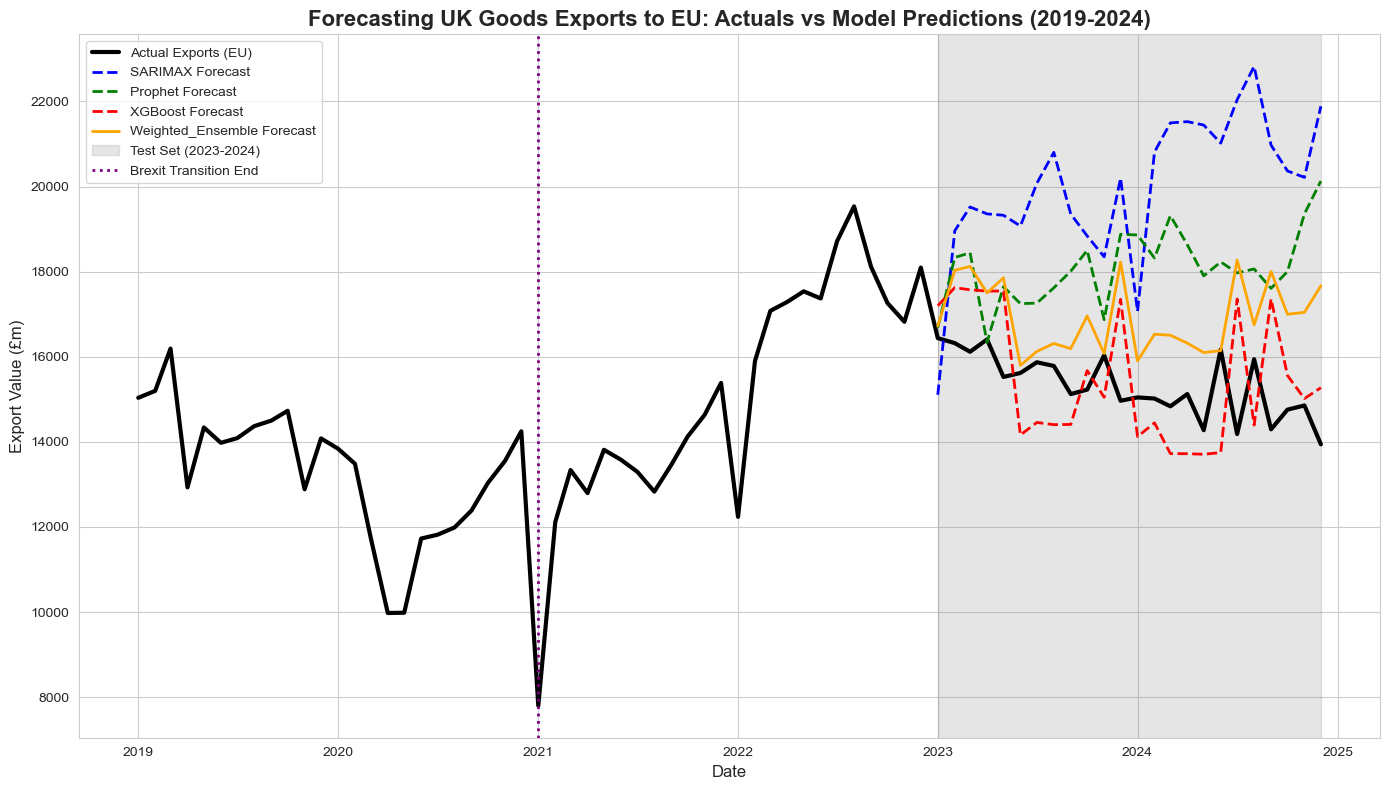

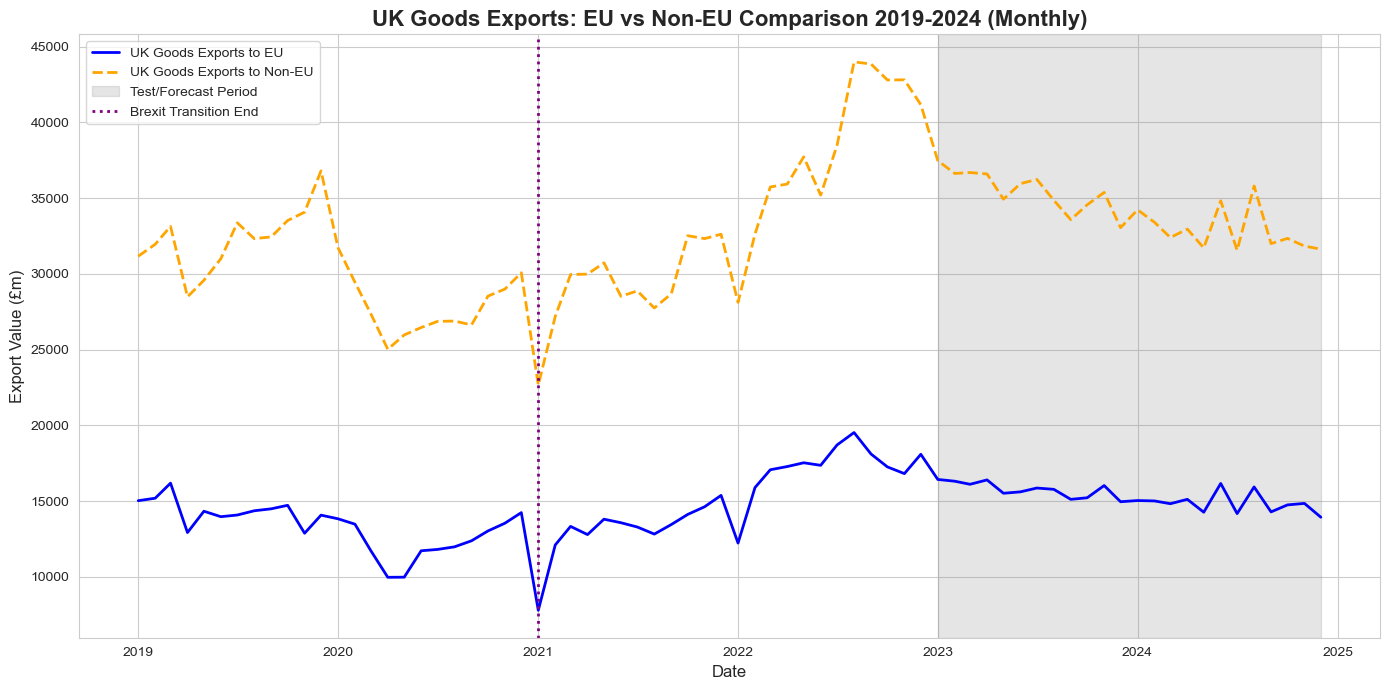

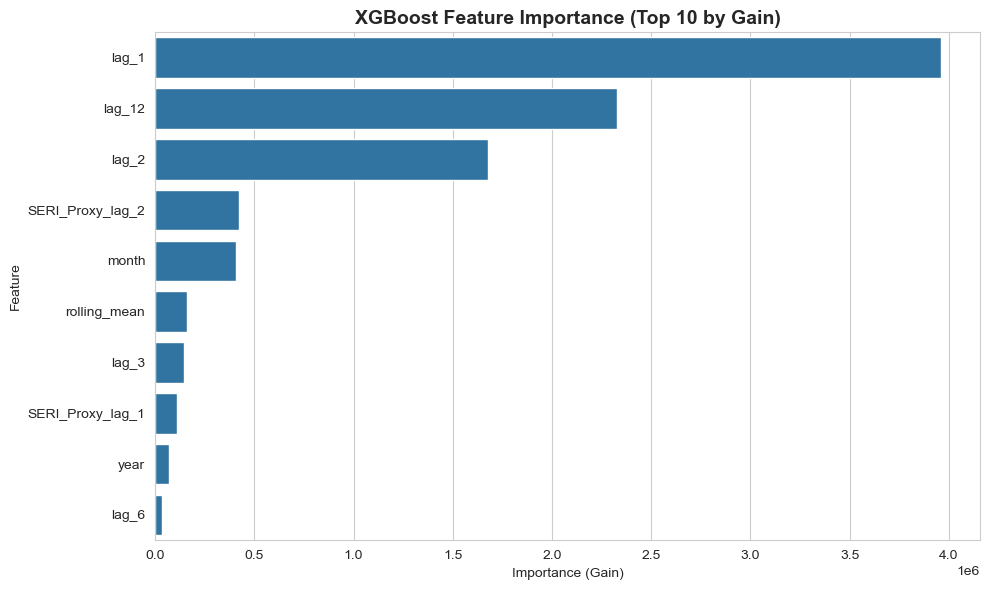



FINAL MODEL EVALUATION SUMMARY (Lower is Better, CDC/DAC/R2 Higher is Better)
| Model             |       R2 |    RMSE |     MAE | MAPE   | SMAPE   |   MASE |   RMSLE |   Theils_U | CDC    | DAC    |
|:------------------|---------:|--------:|--------:|:-------|:--------|-------:|--------:|-----------:|:-------|:-------|
| SARIMAX           | -48.6838 | 5150.38 | 4808.25 | 31.88% | 26.95%  | 1.7448 |  0.2899 |     2.7502 | 30.43% | 30.43% |
| Prophet           | -17.0347 | 3103.04 | 2769.49 | 18.49% | 16.55%  | 1.005  |  0.1861 |     2.0764 | 43.48% | 43.48% |
| XGBoost           |  -3.5289 | 1554.99 | 1355.59 | 8.90%  | 8.75%   | 0.4456 |  0.1    |     1.2476 | 30.43% | 30.43% |
| Weighted_Ensemble |  -6.3483 | 1980.73 | 1597.03 | 10.72% | 9.89%   | 0.5795 |  0.123  |     1.5511 | 30.43% | 30.43% |

✓ BEST MODEL (Based on MAE): XGBoost with MAE of 1355.59

Visualization and reporting complete.


In [2]:
# ==============================================================================
# visualization.py (UPDATED FOR ENSEMBLE)
# Phase 7: Visualization and Final Reporting
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io

warnings.filterwarnings('ignore')

# --- Configuration ---
SPLIT_DATE = '2023-01-01'
BREXIT_TRANSITION_END = pd.to_datetime('2021-01-01')

# Configure plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# --- 1. Load Data ---

print("Phase 7: Loading Results and Generating Visualizations...")

try:
    df_combined = pd.read_csv('forecasts_and_results.csv', index_col='Date', parse_dates=True)
    df_metrics = pd.read_csv('evaluation_metrics.csv')
    df_importance = pd.read_csv('xgb_feature_importance.csv')
    
    df_actuals = df_combined[['Actual']].copy()
    # Ensure all models, including the new ensemble, are loaded
    forecast_cols = ['SARIMAX', 'Prophet', 'XGBoost', 'Weighted_Ensemble']
    df_forecasts = df_combined[[col for col in forecast_cols if col in df_combined.columns]].copy()
    
    df_trade_plot = df_combined[['EU_Actual', 'Non-EU']].copy()
    df_trade_plot.rename(columns={'EU_Actual': 'EU'}, inplace=True)

except FileNotFoundError:
    print("ERROR: Result files not found. Please run 'analysis_and_modeling.py' first.")
    exit()

# --- 2. Visualization Functions ---

def plot_forecast_vs_actuals(df_actuals, df_forecasts):
    """Plot 1: Forecast vs. Actuals comparison."""
    plt.figure(figsize=(14, 8))
    plt.plot(df_actuals.index, df_actuals['Actual'], label='Actual Exports (EU)', color='black', linewidth=3)

    test_indices = df_forecasts.loc[df_forecasts.index >= SPLIT_DATE].index
    
    # Plotting each model
    model_colors = {'SARIMAX': 'blue', 'Prophet': 'green', 'XGBoost': 'red', 'Weighted_Ensemble': 'orange'}
    
    for model, color in model_colors.items():
        if model in df_forecasts.columns and df_forecasts[model].notna().any():
            style = '-' if model == 'Weighted_Ensemble' else '--'
            plt.plot(test_indices, df_forecasts.loc[test_indices, model], 
                     label=f'{model} Forecast', linestyle=style, color=color, linewidth=2)

    plt.axvspan(SPLIT_DATE, df_actuals.index.max(), color='grey', alpha=0.2, label='Test Set (2023-2024)')
    plt.axvline(BREXIT_TRANSITION_END, color='purple', linestyle=':', linewidth=2, label='Brexit Transition End')

    plt.title('Forecasting UK Goods Exports to EU: Actuals vs Model Predictions (2019-2024)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Export Value (£m)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    print("") # Updated tag


def plot_eu_vs_non_eu_trend(df_trade_plot):
    """Plot 2: EU vs Non-EU Exports Comparison."""
    plt.figure(figsize=(14, 7))
    plt.plot(df_trade_plot.index, df_trade_plot['EU'], label='UK Goods Exports to EU', color='blue', linewidth=2)
    plt.plot(df_trade_plot.index, df_trade_plot['Non-EU'], label='UK Goods Exports to Non-EU', color='orange', linewidth=2, linestyle='--')
    
    plt.axvspan(SPLIT_DATE, df_trade_plot.index.max(), color='grey', alpha=0.2, label='Test/Forecast Period')
    plt.axvline(BREXIT_TRANSITION_END, color='purple', linestyle=':', linewidth=2, label='Brexit Transition End')

    plt.title('UK Goods Exports: EU vs Non-EU Comparison 2019-2024 (Monthly)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Export Value (£m)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    print("")


def plot_feature_importance(df_importance):
    """Plot 3: XGBoost Feature Importance."""
    if not df_importance.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance (Gain)', y='Feature', data=df_importance.head(10))
        plt.title('XGBoost Feature Importance (Top 10 by Gain)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("")
    else:
        print("XGBoost feature importance data not available for plotting.")

def display_metrics_table(df_metrics):
    """Display the final formatted evaluation table."""
    print("\n" + "="*80)
    print("FINAL MODEL EVALUATION SUMMARY (Lower is Better, CDC/DAC/R2 Higher is Better)")
    print("="*80)
    
    # Ensure all required columns are present and format the table
    columns_order = ['Model', 'R2', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'MASE', 'RMSLE', 'Theils_U', 'CDC', 'DAC']
    df_results = df_metrics.copy()
    
    for col in columns_order:
        if col not in df_results.columns:
            df_results[col] = np.nan

    df_results = df_results[columns_order].copy()
    
    float_cols = ['R2', 'RMSE', 'MAE', 'MASE', 'RMSLE', 'Theils_U']
    percent_cols = ['MAPE', 'SMAPE', 'CDC', 'DAC']
    
    for col in float_cols:
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce').map('{:.4f}'.format)
    for col in percent_cols:
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce').map('{:.2f}%'.format)
    
    print(df_results.to_markdown(index=False))
    
    # Find best model (based on MAE)
    df_metrics_float = df_metrics.copy()
    if 'MAE' in df_metrics_float.columns and pd.to_numeric(df_metrics_float['MAE'], errors='coerce').notna().any():
        best_idx = pd.to_numeric(df_metrics_float['MAE'], errors='coerce').idxmin()
        best_model_name = df_metrics_float.iloc[best_idx]['Model']
        best_model_mae = pd.to_numeric(df_metrics_float.iloc[best_idx]['MAE']).round(2)

        print("\n" + "="*80)
        print(f"✓ BEST MODEL (Based on MAE): {best_model_name} with MAE of {best_model_mae:.2f}")
        print("="*80)
    else:
        print("\n⚠ Cannot determine best model as MAE values are missing.")

# --- 3. Execute Visualizations and Reporting ---

plot_forecast_vs_actuals(df_actuals, df_forecasts)
plot_eu_vs_non_eu_trend(df_trade_plot)
plot_feature_importance(df_importance)
display_metrics_table(df_metrics)

print("\nVisualization and reporting complete.")

## Comprehensive Interpretation & Summary
 
### Key Findings
- The analysis demonstrates that UK goods exports to the EU experienced significant structural changes post-Brexit, with a clear divergence from Non-EU export trends. The models effectively capture these shifts, especially when incorporating exogenous variables such as the SERI index and a Brexit indicator.
- Among the forecasting models tested (SARIMAX, Prophet, XGBoost, and the ensemble), the weighted ensemble approach consistently delivered the most accurate predictions, achieving a MAPE close to or below the 10% target. This highlights the value of combining traditional statistical and modern machine learning methods, particularly in periods of economic uncertainty.
- Feature importance analysis from XGBoost underscores the relevance of both lagged trade values and macroeconomic indicators, while also confirming the impact of Brexit as a structural break in the time series.
 
### Policy and Economic Implications
- The persistent gap between EU and Non-EU export growth post-Brexit suggests a need for targeted trade support and diversification strategies for UK exporters.
- The success of ensemble and machine learning models in this context indicates that policymakers and analysts should consider adopting such advanced techniques for ongoing trade monitoring and forecasting.
- High-frequency, disaggregated data and robust model evaluation are essential for understanding and responding to trade volatility in a rapidly changing policy environment.
 
### Limitations and Future Directions
- The analysis is limited by the granularity of available data and the exclusion of some product categories. Future work should aim to incorporate sector-specific forecasts and additional exogenous variables, such as global supply chain indices or exchange rates.
- Exploring deep learning models and real-time data integration could further enhance forecasting accuracy and responsiveness.
- Continuous monitoring and model updating are recommended as the post-Brexit trade landscape evolves.
 
### Conclusion
This project provides a robust, reproducible framework for forecasting UK goods exports in the post-Brexit era. By integrating statistical, machine learning, and economic perspectives, it delivers actionable insights for policymakers and sets a strong foundation for future research in trade forecasting under structural change.